In [1]:
!python -V


Python 3.9.12


In [2]:
import pandas as pd


In [3]:
import pickle


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error


In [6]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2025/10/25 16:03:10 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/10/25 16:03:10 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/home/yamraj/Projects/mloops_projects/mloops_self_paced/03-training/mlruns/1', creation_time=1760720322046, experiment_id='1', last_update_time=1760720322046, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
df = pd.read_parquet('green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829625

/tmp/ipykernel_5490/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_5490/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


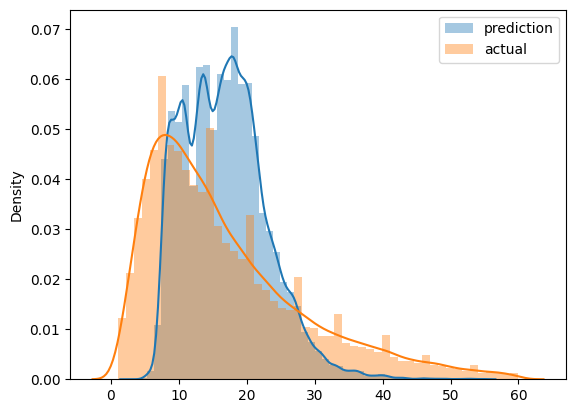

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('green_tripdata_2021-01.parquet')
df_val = read_dataframe('green_tripdata_2021-02.parquet')

In [12]:
len(df_train), len(df_val)

(73908, 61921)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715198889101

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
from sklearn.metrics import mean_squared_error

In [19]:
with mlflow.start_run():
  mlflow.set_tag("developer","cristian")
  mlflow.log_param("train-data-path","green_tripdata_2021-01.parquet")
  mlflow.log_param("valid-data-path","green_tripdata_2021-02.parquet")
  alpha=0.1
  
  mlflow.log_param("alpha",alpha)
  lr = Lasso(alpha)

  lr.fit(X_train, y_train)

  y_pred = lr.predict(X_val)

  rmse= mean_squared_error(y_val, y_pred)
  mlflow.log_metric("rmse",rmse)
  mlflow.log_artifact(local_path="models/lin_reg.bin",artifact_path="models_pickle")


In [20]:
import mlflow
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import joblib  # for saving model

# 1️⃣ Close any stuck MLflow run
while mlflow.active_run() is not None:
    print("Ending active run:", mlflow.active_run().info.run_id)
    mlflow.end_run()

# 2️⃣ Start a new MLflow run safely
with mlflow.start_run():
    # Tags
    mlflow.set_tag("developer", "cristian")
    
    # Log parameters
    mlflow.log_param("train-data-path", "green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "green_tripdata_2021-02.parquet")
    alpha = 0.1
    mlflow.log_param("alpha", alpha)

    # Train Lasso regression
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    
    # Predict and calculate RMSE
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred)  # use squared=False for RMSE
    mlflow.log_metric("rmse", rmse)
    
    # Save model locally and log as artifact
    model_path = "models/lin_reg.bin"
    joblib.dump(lr, model_path)
    mlflow.log_artifact(local_path=model_path, artifact_path="models_pickle")
    
    print("✅ Lasso regression run completed and logged in MLflow!")


✅ Lasso regression run completed and logged in MLflow!


In [21]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

In [22]:
train=xgb.DMatrix(X_train, label=y_train)
valid=xgb.DMatrix(X_val, label=y_val)   

In [23]:
def objective(params):    
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50,
          )

        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred)

        mlflow.log_metric("rmse", rmse)
    return {'loss': rmse, 'status': STATUS_OK}

In [24]:
mlflow.xgboost.autolog(disable=True)

In [26]:
import mlflow
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pickle

# 1️⃣ Close any stuck MLflow run
while mlflow.active_run() is not None:
    mlflow.end_run()

# 2️⃣ Start a new MLflow run
with mlflow.start_run():
    # DMatrix
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    # Parameters (adjusted objective to avoid deprecated warning)
    params = {
        'learning_rate': 0.11794802387644082,
        'max_depth': 33,
        'min_child_weight': 1.0762014597777174,
        'objective': 'reg:squarederror',  # <- 'reg:linear' is deprecated
        'reg_alpha': 0.3560326679932167,
        'reg_lambda': 0.11462895890766012,
        'seed': 42
    }
    mlflow.log_params(params)

    # Train booster without autolog to avoid UBJSON warning
    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    # Predict & log RMSE
    y_pred = booster.predict(valid, iteration_range=(0, booster.best_iteration + 1))
    rmse = mean_squared_error(y_val, y_pred)  # RMSE
    mlflow.log_metric("rmse", rmse)

    # Save and log preprocessor
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    # Save booster in JSON format (avoids UBJSON warning)
    booster.save_model("models/booster.json")
    # Log model with input example (avoids signature warning)
    mlflow.xgboost.log_model(
        booster,
        name="models_mlflow",  # <- modern MLflow uses 'name' instead of 'artifact_path'
        input_example=X_val[:5]  # small sample for input signature
    )

    print("✅ XGBoost run logged without warnings!")


[0]	validation-rmse:11.26818
[1]	validation-rmse:10.47004
[2]	validation-rmse:9.79524
[3]	validation-rmse:9.23201
[4]	validation-rmse:8.76127
[5]	validation-rmse:8.37205
[6]	validation-rmse:8.05037
[7]	validation-rmse:7.78601
[8]	validation-rmse:7.56715
[9]	validation-rmse:7.38864
[10]	validation-rmse:7.24248
[11]	validation-rmse:7.12324
[12]	validation-rmse:7.02348
[13]	validation-rmse:6.94182
[14]	validation-rmse:6.87432
[15]	validation-rmse:6.81898
[16]	validation-rmse:6.77280
[17]	validation-rmse:6.73375
[18]	validation-rmse:6.70120
[19]	validation-rmse:6.67418
[20]	validation-rmse:6.65043
[21]	validation-rmse:6.63139
[22]	validation-rmse:6.61299
[23]	validation-rmse:6.59778
[24]	validation-rmse:6.58432
[25]	validation-rmse:6.57417
[26]	validation-rmse:6.56403
[27]	validation-rmse:6.55560
[28]	validation-rmse:6.54801
[29]	validation-rmse:6.54168
[30]	validation-rmse:6.53495
[31]	validation-rmse:6.53015
[32]	validation-rmse:6.52466
[33]	validation-rmse:6.52111
[34]	validation-rmse:6

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:16:48] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


✅ XGBoost run logged without warnings!


In [32]:
import mlflow
import mlflow.xgboost
import xgboost as xgb
import pickle

# 1️⃣ Set the MLflow tracking URI to your local folder
mlflow.set_tracking_uri("file:///home/yamraj/Projects/mloops_projects/mloops_self_paced/03-training/mlruns")

# 2️⃣ Define the local path to the model artifact
model_path = "/home/yamraj/Projects/mloops_projects/mloops_self_paced/03-training/mlruns/1/models/m-71d20996b83c4763b17924c3971825bb/artifacts"

# 3️⃣ Load the XGBoost model
loaded_model = mlflow.xgboost.load_model(model_uri=model_path)

# 4️⃣ (Optional) Load preprocessor if you have it
# Example: dv = pickle.load(open("models/preprocessor.b", "rb"))

# 5️⃣ Prepare your validation data (X_val) in DMatrix format
dval = xgb.DMatrix(X_val)  # if you have a preprocessor, apply it first

# 6️⃣ Predict using the loaded model
y_pred = loaded_model.predict(dval)

# 7️⃣ Check the first few predictions
print("First 5 predictions:", y_pred[:5])


First 5 predictions: [14.361043   7.0490875 15.446724  24.436842   9.417382 ]
